# 3. Approche supervisée.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import joblib
import boto3
import os

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
%cd ..
import src.mytools as mt
%cd notebooks

/home/chakir/Bureau/PROJETS/Projet5/env/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/home/chakir/Bureau/PROJETS/Projet5
/home/chakir/Bureau/PROJETS/Projet5/notebooks


/home/chakir/Bureau/PROJETS/Projet5/env/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


## 3.1 Préparation des données.

In [3]:
mlflow.set_tracking_uri("http://ec2-52-209-5-80.eu-west-1.compute.amazonaws.com:5000")

Nous allons créer une expérience **approches_supervisées** dans laquelle nous enregistrerons nos runs :

In [4]:
mlflow.set_experiment('approches_supervisees')

<Experiment: artifact_location='s3://mlflow-cfikri/795809222013714058', creation_time=1718661275383, experiment_id='795809222013714058', last_update_time=1718661275383, lifecycle_stage='active', name='approches_supervisees', tags={}>

On charge le dataset d'entraînement :

In [5]:
data = pd.read_csv('../data/questions_pretraitees.csv')
data.set_index('Id', inplace=True)
data.head()

,Title,Body,Tags,Score,ViewCount,AnswerCount
Id,,,,,,
26170029,touchstart touchend angularjs,element fire function code mousedown code code...,mouseup angularjs touchstart javascript mousedown,16,39388,3
21912226,find current element mouseover jquery,class current element mouseover example img sr...,mouseover jquery html javascript mouseout,26,103946,8
32974173,open git terminal mac,instal git code usr local code mac href http g...,shell git terminal bash macos,8,103356,5
2197775,use multibinding wpf combobox,drive nuts \n\n code combobox code filte...,bind wpf xaml ivalueconverter data,7,30176,3
9153571,way version package json file node code,way version set href https doc npmjs com cli c...,node version package json versione npm,921,561172,34


In [6]:
data[data.Title.isna()].shape

(1, 6)

On traite les deux valeurs manquantes comme dans le notebook précédent :

In [7]:
condition = data.Title.isna()
data.loc[condition, 'Title'] = data.loc[condition, 'Body']

In [8]:
condition = data.Body.isna()
data.loc[condition, 'Body'] = data.loc[condition, 'Title']

In [9]:
mt.valeurs_manquantes(data)

,effectif,taux


On charge les données de test :

In [10]:
data_val = pd.read_csv('../data/questions_pretraitees_validation.csv')
data_val.set_index('Id', inplace=True)
data_val.head()

,Title,Body,Tags,Score,ViewCount,AnswerCount
Id,,,,,,
15388206,send json response fail passport authentication,code node code backend api server iphone clien...,authentication node javascript local passport,69,60579,6
8004707,responsive website iphone unwanted white space...,create responsive website notice strange behav...,iphone design responsive whitespace orientatio...,38,56345,13
27211012,send json object rest client javax client webt...,pojo give want server json xml \n\n \n\n str...,jersey- jersey java client jax rest,28,117913,1
12138339,find index specific color value image store nu...,image store numpy array yield code imread ...,multidimensional python rgb array numpy image,21,30645,1
56153726,plot nearest neighbor graph feature,new machine learning like setup little sample ...,scikit python machine plot near neighbor learn,15,45087,2


## 3.2 Classification avec Bag-of-words TF-IDF

### 3.2.1 CRÉATION DES BAG-OF-WORDS

Nous allons créer un bag-of-words d'entraînement et un bag-of-words de test. Pour que les durées d'entraînement des modèles soient raisonnables, nous allons limiter le nombre de features à 5000 :

In [11]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [12]:
# Créer une matrice TF-IDF pour les données textuelles :
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')

bow = vectorizer.fit_transform(data.Title + ' ' + data.Body)
bow_val = vectorizer.transform(data_val.Title + ' ' + data_val.Body)

X = pd.DataFrame(bow.toarray(), index=data.index, columns=vectorizer.get_feature_names_out())
X_val = pd.DataFrame(bow_val.toarray(), index=data_val.index, columns=vectorizer.get_feature_names_out())

In [13]:
X.head()

,aaa,aac,aapt,aar,ab,abc,abcd,abi,ability,able,...,zipcode,zipfile,zlib,zone,zoneddatetime,zookeeper,zoom,zsh,zxe,zygoteinit
Id,,,,,,,,,,,,,,,,,,,,,
26170029,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21912226,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32974173,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2197775,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9153571,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
mt.valeurs_manquantes(X_val)

,effectif,taux


In [15]:
# Enregistrer le vectorizer avec MLflow

with mlflow.start_run(run_name="TfidfVectorizer") as run:
    # Enregistrer le vectorizer en tant qu'artefact personnalisé
    vectorizer_path = "vectorizer.pkl"
    joblib.dump(vectorizer, vectorizer_path)
    mlflow.log_artifact(vectorizer_path, "tfidf_vectorizer")
    # Supprimer le fichier local après l'avoir enregistré dans MLflow
    os.remove(vectorizer_path)

Nous allons binariser la variable cible contenant les tags. Pour la même raison que précédemment, nous allons limiter le nombre de tags au 500 tags les plus fréquents :

In [16]:
binarizer = CountVectorizer(binary=True, max_features=500, stop_words='english')

bow_cible = binarizer.fit_transform(data.Tags)
bow_val_cible = binarizer.transform(data_val.Tags)

y = pd.DataFrame(bow_cible.toarray(), index=data.index, columns=binarizer.get_feature_names_out())
y_val = pd.DataFrame(bow_val_cible.toarray(), index=data_val.index, columns=binarizer.get_feature_names_out())

In [17]:
y.shape

(25000, 500)

In [18]:
# Enregistrer le binarizer avec MLflow

with mlflow.start_run(run_name="Binarizer") as run:
    # Enregistrer le binarizer en tant qu'artefact personnalisé
    binarizer_path = "binarizer.pkl"
    joblib.dump(binarizer, binarizer_path)
    mlflow.log_artifact(binarizer_path, "binarizer")
    # Supprimer le fichier local après l'avoir enregistré dans MLflow
    os.remove(binarizer_path)

### 3.2.2 REGRESSION LOGISTIQUE

In [19]:
from time import time
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import jaccard_score

Tous les algorithmes que nous allons entraîner seront optimisés en maximisant le Jaccard Score et le taux de couverture des tags. Le Jaccard score représente la proportion d'éléments communs à deux ensembles. Il sera calculé en calculant la moyenne pondéré des scores de chaque colonne (option average='weighted').

In [22]:
debut = time()

classifier = OneVsRestClassifier(LogisticRegression())
classifier.fit(X, y)
y_pred = classifier.predict(X_val)

fin = time()

duree = fin - debut
print(f"Durée d'exécution : {round(duree/60)} minutes")

Durée d'exécution : 23 minutes


In [23]:
score_reference = jaccard_score(y_val, y_pred, average='weighted')
score_reference

0.28138262211568615

In [24]:
tags_pred = pd.Series(binarizer.inverse_transform(y_pred), index=data_val.index).apply(lambda x: ' '.join(x))
coverage_reference = mt.coverage_score(tags_pred, data_val.Tags)
coverage_reference

0.2112247157287006

Ces Jaccard Score et taux de couverture de référence nous serviront de baseline pour les modèles suivants.

On enregistre ce modèle dans MLflow :

In [25]:
params = {'algorithme' : 'LogisticRegression'}
metrics = {'jaccard_score' : score_reference,
           'taux_de_couverture' : coverage_reference}
tags = {'Dataset' : 'BOW_tfidf', 'algorithme' : 'LogisticRegression'}

mt.log_mlflow_run('Regression logistique (TF-IDF)', params, metrics, tags=tags, model=classifier, model_name='LogisticRegression')

### 3.2.3 SGDClassifier AVEC UNE PÉNALITÉ L2

In [47]:
debut = time()

alphas = np.logspace(-8, -4, 10)
score = []
coverage = []

for alpha in alphas:
    classifier = OneVsRestClassifier(SGDClassifier(alpha=alpha, penalty='l2', loss='log_loss', random_state=72))
    classifier.fit(X, y)
    
    y_pred = classifier.predict(X_val)
    score.append(jaccard_score(y_val, y_pred, average='weighted'))
    
    tags_pred = pd.Series(binarizer.inverse_transform(y_pred), index=data_val.index).apply(lambda x: ' '.join(x))
    coverage.append(mt.coverage_score(tags_pred, data_val.Tags))

fin = time()

duree = fin - debut
print(f"Durée d'exécution : {round(duree/60)} minutes")

Durée d'exécution : 356 minutes


/home/chakir/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/chakir/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/chakir/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/chakir/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Conver

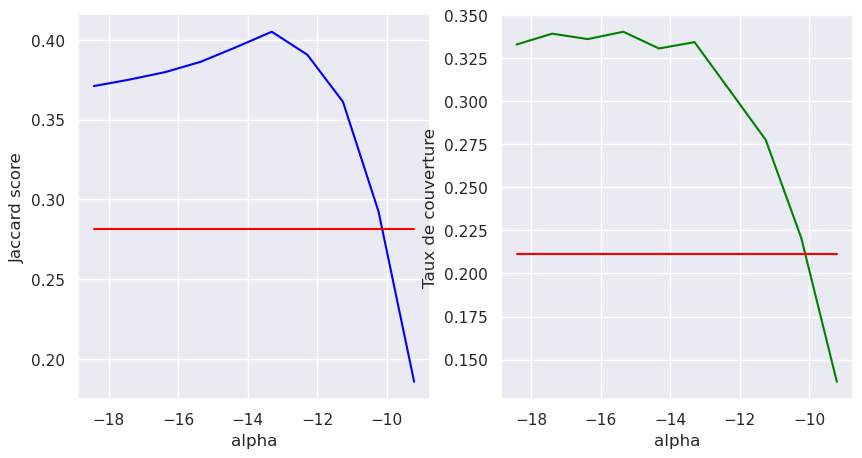

In [48]:
sns.set(style='darkgrid')
fig, axe = plt.subplots(1,2,figsize = (10,5))
axe = axe.flatten()
sns.lineplot(x=np.log(alphas), y=score, ax=axe[0], color='blue')
sns.lineplot(x=np.log(alphas), y=score_reference, ax=axe[0], color='red')
axe[0].set_xlabel('alpha')
axe[0].set_ylabel('Jaccard score')
sns.lineplot(x=np.log(alphas), y=coverage, ax=axe[1], color='green')
sns.lineplot(x=np.log(alphas), y=coverage_reference, ax=axe[1], color='red')
axe[1].set_xlabel('alpha')
axe[1].set_ylabel('Taux de couverture')
plt.savefig('../outputs/Jaccard score et taux de couverture en fonction de alpha (SGD_l2_bow).png')
plt.show()

In [49]:
alpha_optimal = alphas[np.argmax(coverage)]
alpha_optimal

2.1544346900318822e-07

In [50]:
score[np.argmax(coverage)]

0.38621746777597166

In [51]:
max(coverage)

0.3404027864357682

On observe clairement un effet positif de la régularisation : On passe d'un taux de couverture de 21% à un taux de 34%. Nous allons voir si l'on peux faire mieux avec un régularisation L1.

In [ ]:
classifier = OneVsRestClassifier(SGDClassifier(alpha=alpha_optimal, penalty='l2', loss='log_loss', random_state=72))
classifier.fit(X, y)

On enregistre ce modèle dans MLflow :

In [78]:
params = {'algorithme' : 'SGDClassifier', 'loss' : 'log_loss', 'penalty' : 'l2', 'alpha_optimal' : alpha_optimal}
metrics = {'jaccard_score' : score[np.argmax(coverage)],
           'taux_de_couverture' : max(coverage)}
tags = {'Dataset' : 'BOW_tfidf', 'algorithme' : 'SGDClassifier'}
artifacts = {'Evolution du Jaccard score et du taux de couverture en fonction de alpha' : 
             '../outputs/Jaccard score et taux de couverture en fonction de alpha (SGD_l2_bow).png'}

mt.log_mlflow_run('SGDClassifier_l2 (TF-IDF)', params, metrics, tags=tags, artifacts=artifacts,\
                  model=classifier, model_name='SGDClassifier')

/home/chakir/anaconda3/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/home/chakir/anaconda3/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


### 3.2.4 SGDClassifier AVEC UNE PÉNALITÉ L1

In [81]:
debut = time()

alphas = np.logspace(-8, -4, 10)
score = []
coverage = []

for alpha in alphas:
    classifier = OneVsRestClassifier(SGDClassifier(alpha=alpha, penalty='l1', loss='log_loss', random_state=72))
    classifier.fit(X, y)
    
    y_pred = classifier.predict(X_val)
    score.append(jaccard_score(y_val, y_pred, average='weighted'))
    
    tags_pred = pd.Series(binarizer.inverse_transform(y_pred), index=data_val.index).apply(lambda x: ' '.join(x))
    coverage.append(mt.coverage_score(tags_pred, data_val.Tags))

fin = time()

duree = fin - debut
print(f"Durée d'exécution : {round(duree/60)} minutes")

Durée d'exécution : 811 minutes


/home/chakir/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/chakir/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/chakir/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/chakir/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Conver

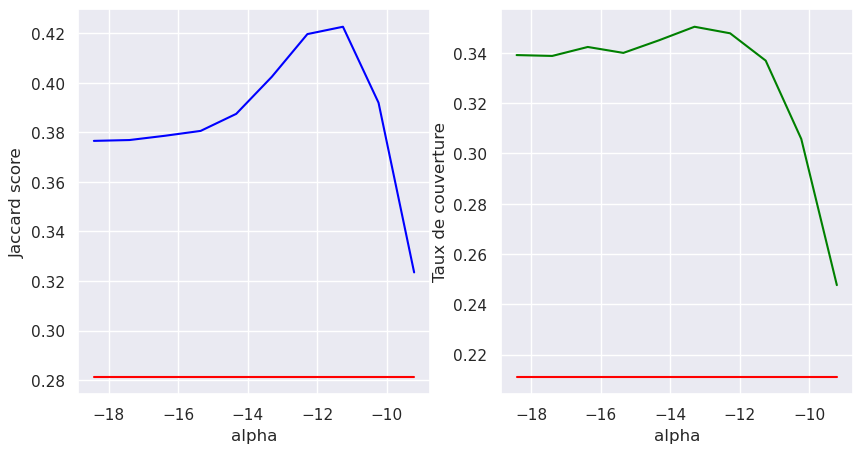

In [82]:
sns.set(style='darkgrid')
fig, axe = plt.subplots(1,2,figsize = (10,5))
axe = axe.flatten()
sns.lineplot(x=np.log(alphas), y=score, ax=axe[0], color='blue')
sns.lineplot(x=np.log(alphas), y=score_reference, ax=axe[0], color='red')
axe[0].set_xlabel('alpha')
axe[0].set_ylabel('Jaccard score')
sns.lineplot(x=np.log(alphas), y=coverage, ax=axe[1], color='green')
sns.lineplot(x=np.log(alphas), y=coverage_reference, ax=axe[1], color='red')
axe[1].set_xlabel('alpha')
axe[1].set_ylabel('Taux de couverture')
plt.savefig('../outputs/Jaccard score et taux de couverture en fonction de alpha (SGD_l1_bow).png')
plt.show()

In [83]:
alpha_optimal = alphas[np.argmax(coverage)]
alpha_optimal

1.6681005372000591e-06

In [84]:
score[np.argmax(coverage)]

0.4024134296637863

In [92]:
max(coverage)

0.35036893217891496

In [22]:
alpha_optimal = 1.6681005372000591e-06
score = 0.4024134296637863
coverage = 0.35036893217891496

In [23]:
classifier = OneVsRestClassifier(SGDClassifier(alpha=alpha_optimal, penalty='l1', loss='log_loss', random_state=72))
classifier.fit(X, y)

OneVsRestClassifier(estimator=SGDClassifier(alpha=1.6681005372000591e-06,
                                            loss='log_loss', penalty='l1',
                                            random_state=72))

In [25]:
params = {'algorithme' : 'SGDClassifier', 'loss' : 'log_loss', 'penalty' : 'l1', 'alpha_optimal' : alpha_optimal}
metrics = {'jaccard_score' : score,
           'taux_de_couverture' : coverage}
tags = {'Dataset' : 'BOW_tfidf', 'algorithme' : 'SGDClassifier'}
artifacts = {'Evolution du Jaccard score et du taux de couverture en fonction de alpha' : 
             '../outputs/Jaccard score et taux de couverture en fonction de alpha (SGD_l1_bow).png'}

mt.log_mlflow_run('SGDClassifier_l1 (TF-IDF)', params, metrics, tags=tags, artifacts=artifacts,\
                  model=classifier, model_name='SGDClassifier')

In [94]:
params = {'algorithme' : 'SGDClassifier', 'loss' : 'log_loss', 'penalty' : 'l1', 'alpha_optimal' : alpha_optimal}
metrics = {'jaccard_score' : score[np.argmax(coverage)],
           'taux_de_couverture' : max(coverage)}
tags = {'Dataset' : 'BOW_tfidf', 'algorithme' : 'SGDClassifier'}
artifacts = {'Evolution du Jaccard score et du taux de couverture en fonction de alpha' : 
             '../outputs/Jaccard score et taux de couverture en fonction de alpha (SGD_l1_bow).png'}

mt.log_mlflow_run('SGDClassifier_l1 (TF-IDF)', params, metrics, tags=tags, artifacts=artifacts,\
                  model=classifier, model_name='SGDClassifier')

/home/chakir/anaconda3/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/home/chakir/anaconda3/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


## 3.3 Classification avec Embedding Word2Vec

### 3.3.1 CRÉATION DES EMBEDDINGS

In [32]:
from gensim.models import Word2Vec

Nous allons représenter chaque 'titre + question' par un vecteur de taille 100 avec Word2Vec. Le modèle Word2Vec sera entraîné uniquement sur les titres et les questions du dataset d'entraînement.

Nous utiliserons ensuite les embeddings obtenus pour entraîner les mêmes modèles que ceux entraînés avec les bag-of-words précédents.

In [35]:
sentences = [title.split() for title in data.Title] + [question.split() for question in data.Body]
embedding = Word2Vec(sentences, vector_size=100, min_count=1, sg=1, window=7)

In [36]:
embedding.wv.most_similar('tensorflow')

[('keras', 0.8336083292961121),
 ('kera', 0.8083258271217346),
 ('pytorch', 0.7873112559318542),
 ('theano', 0.7819665670394897),
 ('vgg', 0.7774200439453125),
 ('estimator', 0.7772973775863647),
 ('futurewarning', 0.7729784846305847),
 ('tensorboard', 0.7696813941001892),
 ('factorization', 0.7695174217224121),
 ('scikit', 0.7676658630371094)]

La fonction ci-dessous permet d'obtenir l'embedding d'un document à partir de l'embedding de chacun de ses tokens :

In [38]:
def get_vector(embedding, text):
    return np.mean([embedding.wv[word] for word in text.split() if word in embedding.wv], axis=0)

On calcule les embeddings de chaque 'titre + question' des datasets d'entraînement et de test.

In [40]:
X = pd.DataFrame((data.Title + ' ' + data.Body).apply(lambda x: get_vector(embedding, x)).tolist(), index=data.index)
X_val = pd.DataFrame((data_val.Title + ' ' + data_val.Body).apply(lambda x: get_vector(embedding, x)).tolist(), index=data_val.index)

In [41]:
X.shape

(25000, 100)

### 3.3.2 RÉGRESSION LOGISTIQUE

In [108]:
debut = time()

classifier = OneVsRestClassifier(LogisticRegression())
classifier.fit(X, y)
y_pred = classifier.predict(X_val)

fin = time()

duree = fin - debut
print(f"Durée d'exécution : {round(duree/60)} minutes")

Durée d'exécution : 1 minutes


In [109]:
score_reference = jaccard_score(y_val, y_pred, average='weighted')
score_reference

0.23749695193199377

In [110]:
tags_pred = pd.Series(binarizer.inverse_transform(y_pred), index=data_val.index).apply(lambda x: ' '.join(x))
coverage_reference = mt.coverage_score(tags_pred, data_val.Tags)
coverage_reference

0.18739467965366838

In [115]:
params = {'algorithme' : 'LogisticRegression'}
metrics = {'jaccard_score' : score_reference,
           'taux_de_couverture' : coverage_reference}
tags = {'Dataset' : 'Word2Vec', 'algorithme' : 'SGDClassifier'}

mt.log_mlflow_run('Regression logistique (Word2Vec)', params, metrics, tags=tags, model=classifier, model_name='LogisticRegression')

### 3.3.3 SGDClassifier AVEC UNE PÉNALITÉ L2

In [119]:
debut = time()

alphas = np.logspace(-8, -4, 10)
score = []
coverage = []

for alpha in alphas:
    classifier = OneVsRestClassifier(SGDClassifier(alpha=alpha, penalty='l2', loss='log_loss', random_state=72))
    classifier.fit(X, y)
    
    y_pred = classifier.predict(X_val)
    score.append(jaccard_score(y_val, y_pred, average='weighted'))
    
    tags_pred = pd.Series(binarizer.inverse_transform(y_pred), index=data_val.index).apply(lambda x: ' '.join(x))
    coverage.append(mt.coverage_score(tags_pred, data_val.Tags))

fin = time()

duree = fin - debut
print(f"Durée d'exécution : {round(duree/60)} minutes")

Durée d'exécution : 30 minutes


/home/chakir/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/chakir/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/chakir/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/chakir/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Conver

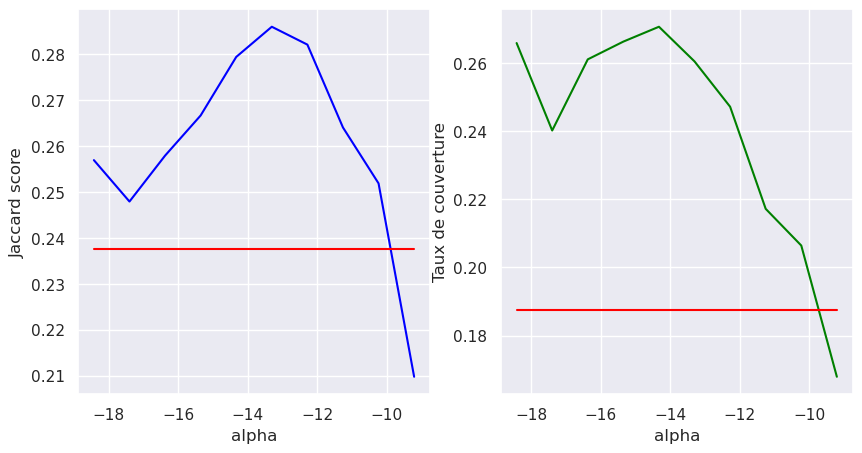

In [120]:
sns.set(style='darkgrid')
fig, axe = plt.subplots(1,2,figsize = (10,5))
axe = axe.flatten()
sns.lineplot(x=np.log(alphas), y=score, ax=axe[0], color='blue')
sns.lineplot(x=np.log(alphas), y=score_reference, ax=axe[0], color='red')
axe[0].set_xlabel('alpha')
axe[0].set_ylabel('Jaccard score')
sns.lineplot(x=np.log(alphas), y=coverage, ax=axe[1], color='green')
sns.lineplot(x=np.log(alphas), y=coverage_reference, ax=axe[1], color='red')
axe[1].set_xlabel('alpha')
axe[1].set_ylabel('Taux de couverture')
plt.savefig('../outputs/Jaccard score et taux de couverture en fonction de alpha (SGD_l2_w2v).png')
plt.show()

In [121]:
alpha_optimal = alphas[np.argmax(coverage)]
alpha_optimal

5.994842503189409e-07

In [122]:
score[np.argmax(coverage)]

0.279410102120984

In [123]:
max(coverage)

0.27072538816736935

In [219]:
classifier = OneVsRestClassifier(SGDClassifier(alpha=alpha_optimal, penalty='l2', loss='log_loss', random_state=72))
classifier.fit(X, y)

OneVsRestClassifier(estimator=SGDClassifier(alpha=5.994842503189409e-07,
                                            loss='log_loss', random_state=72))

In [124]:
params = {'algorithme' : 'SGDClassifier', 'loss' : 'log_loss', 'penalty' : 'l2', 'alpha_optimal' : alpha_optimal}
metrics = {'jaccard_score' : score[np.argmax(coverage)],
           'taux_de_couverture' : max(coverage)}
tags = {'Dataset' : 'Word2Vec', 'algorithme' : 'SGDClassifier'}
artifacts = {'Evolution du Jaccard score et du taux de couverture en fonction de alpha' : 
             '../outputs/Jaccard score et taux de couverture en fonction de alpha (SGD_l2_w2v).png'}

mt.log_mlflow_run('SGDClassifier_l2 (Word2Vec)', params, metrics, tags=tags, artifacts=artifacts,\
                  model=classifier, model_name='SGDClassifier')

/home/chakir/anaconda3/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/home/chakir/anaconda3/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


### 3.3.4 SGDClassifier AVEC UNE PÉNALITÉ L1

In [129]:
debut = time()

alphas = np.logspace(-8, -4, 10)
score = []
coverage = []

for alpha in alphas:
    classifier = OneVsRestClassifier(SGDClassifier(alpha=alpha, penalty='l1', loss='log_loss', random_state=72))
    classifier.fit(X, y)
    
    y_pred = classifier.predict(X_val)
    score.append(jaccard_score(y_val, y_pred, average='weighted'))
    
    tags_pred = pd.Series(binarizer.inverse_transform(y_pred), index=data_val.index).apply(lambda x: ' '.join(x))
    coverage.append(mt.coverage_score(tags_pred, data_val.Tags))

fin = time()

duree = fin - debut
print(f"Durée d'exécution : {round(duree/60)} minutes")

Durée d'exécution : 67 minutes


/home/chakir/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/chakir/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/chakir/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/chakir/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Conver

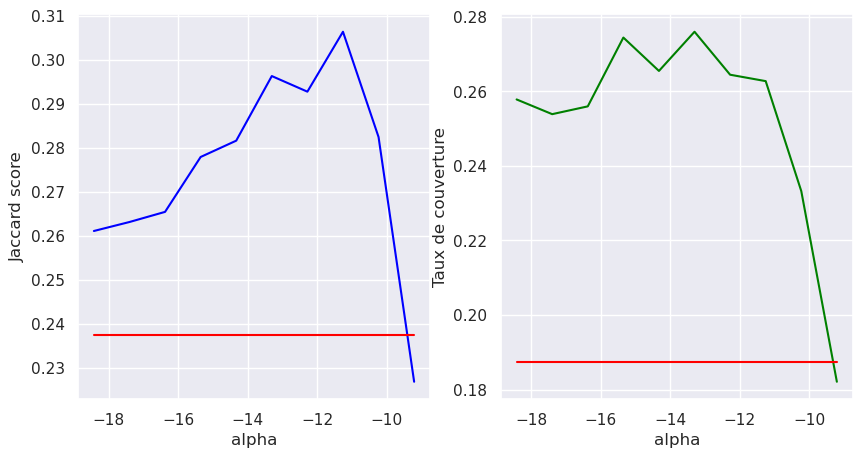

In [130]:
sns.set(style='darkgrid')
fig, axe = plt.subplots(1,2,figsize = (10,5))
axe = axe.flatten()
sns.lineplot(x=np.log(alphas), y=score, ax=axe[0], color='blue')
sns.lineplot(x=np.log(alphas), y=score_reference, ax=axe[0], color='red')
axe[0].set_xlabel('alpha')
axe[0].set_ylabel('Jaccard score')
sns.lineplot(x=np.log(alphas), y=coverage, ax=axe[1], color='green')
sns.lineplot(x=np.log(alphas), y=coverage_reference, ax=axe[1], color='red')
axe[1].set_xlabel('alpha')
axe[1].set_ylabel('Taux de couverture')
plt.savefig('../outputs/Jaccard score et taux de couverture en fonction de alpha (SGD_l1_w2v).png')
plt.show()

In [131]:
alpha_optimal = alphas[np.argmax(coverage)]
alpha_optimal

1.6681005372000591e-06

In [132]:
score[np.argmax(coverage)]

0.29629004105830437

In [133]:
max(coverage)

0.27600773593071476

In [225]:
classifier = OneVsRestClassifier(SGDClassifier(alpha=alpha_optimal, penalty='l1', loss='log_loss', random_state=72))
classifier.fit(X, y)

OneVsRestClassifier(estimator=SGDClassifier(alpha=1.6681005372000591e-06,
                                            loss='log_loss', penalty='l1',
                                            random_state=72))

In [134]:
params = {'algorithme' : 'SGDClassifier', 'loss' : 'log_loss', 'penalty' : 'l1', 'alpha_optimal' : alpha_optimal}
metrics = {'jaccard_score' : score[np.argmax(coverage)],
           'taux_de_couverture' : max(coverage)}
tags = {'Dataset' : 'Word2Vec', 'algorithme' : 'SGDClassifier'}
artifacts = {'Evolution du Jaccard score et du taux de couverture en fonction de alpha' : 
             '../outputs/Jaccard score et taux de couverture en fonction de alpha (SGD_l1_w2v).png'}

mt.log_mlflow_run('SGDClassifier_l1 (Word2Vec)', params, metrics, tags=tags, artifacts=artifacts,\
                  model=classifier, model_name='SGDClassifier')

/home/chakir/anaconda3/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/home/chakir/anaconda3/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


## 3.4 Classification avec Embedding BERT

### 3.4.1 CRÉATION DES EMBEDDINGS

En raison de contraintes en mémoire RAM et temps de calcul, nous allons utiliser une version allégée de BERT (DistilBERT) et nous allons construire les embeddings en plusieurs fois, paquets par paquets.

In [15]:
from transformers import DistilBertTokenizer, DistilBertModel
import torch

In [16]:
# Charger le tokenizer et le modèle BERT pré-entraîné
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')

# Fonction pour obtenir les embeddings BERT (par lot)
def get_bert_embeddings(texts, batch_size=32):
    all_embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        inputs = tokenizer(batch_texts, return_tensors='pt', padding=True, truncation=True, max_length=32)
        with torch.no_grad():
            outputs = model(**inputs)
        batch_embeddings = outputs.last_hidden_state[:, 0, :].numpy()
        all_embeddings.append(batch_embeddings)
    return np.concatenate(all_embeddings, axis=0)

In [17]:
# Obtenir les embeddings pour l'ensemble d'entraînement et de test
bert = get_bert_embeddings((data.Title + ' ' + data.Body).tolist())
bert_val = get_bert_embeddings((data_val.Title + ' ' + data_val.Body).tolist())

In [19]:
bert.shape

(25000, 768)

### 3.4.2 RÉGRESSION LOGISTIQUE

In [26]:
debut = time()

classifier = OneVsRestClassifier(LogisticRegression(max_iter=300))
classifier.fit(bert, y)
y_pred = classifier.predict(bert_val)

fin = time()

duree = fin - debut
print(f"Durée d'exécution : {round(duree/60)} minutes")

/home/chakir/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Durée d'exécution : 19 minutes


In [27]:
score_reference = jaccard_score(y_val, y_pred, average='weighted')
score_reference

0.23491179672433335

In [28]:
tags_pred = pd.Series(binarizer.inverse_transform(y_pred), index=data_val.index).apply(lambda x: ' '.join(x))
coverage_reference = mt.coverage_score(tags_pred, data_val.Tags)
coverage_reference

0.18145012554111442

In [29]:
params = {'algorithme' : 'LogisticRegression'}
metrics = {'jaccard_score' : score_reference,
           'taux_de_couverture' : coverage_reference}
tags = {'Dataset' : 'BERT', 'algorithme' : 'LogisticRegression'}

mt.log_mlflow_run('Regression logistique (BERT)', params, metrics, tags=tags, model=classifier, model_name='LogisticRegression')

### 3.4.3 SGDClassifier AVEC UNE PÉNALITÉ L2

In [30]:
debut = time()

alphas = np.logspace(-8, -4, 10)
score = []
coverage = []

for alpha in alphas:
    classifier = OneVsRestClassifier(SGDClassifier(alpha=alpha, penalty='l2', loss='log_loss', random_state=72))
    classifier.fit(bert, y)
    
    y_pred = classifier.predict(bert_val)
    score.append(jaccard_score(y_val, y_pred, average='weighted'))
    
    tags_pred = pd.Series(binarizer.inverse_transform(y_pred), index=data_val.index).apply(lambda x: ' '.join(x))
    coverage.append(mt.coverage_score(tags_pred, data_val.Tags))

fin = time()

duree = fin - debut
print(f"Durée d'exécution : {round(duree/60)} minutes")

Durée d'exécution : 235 minutes


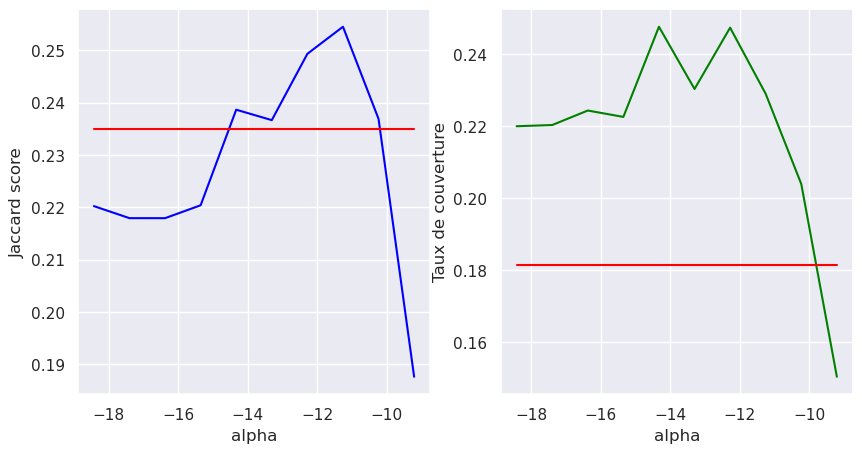

In [31]:
sns.set(style='darkgrid')
fig, axe = plt.subplots(1,2,figsize = (10,5))
axe = axe.flatten()
sns.lineplot(x=np.log(alphas), y=score, ax=axe[0], color='blue')
sns.lineplot(x=np.log(alphas), y=score_reference, ax=axe[0], color='red')
axe[0].set_xlabel('alpha')
axe[0].set_ylabel('Jaccard score')
sns.lineplot(x=np.log(alphas), y=coverage, ax=axe[1], color='green')
sns.lineplot(x=np.log(alphas), y=coverage_reference, ax=axe[1], color='red')
axe[1].set_xlabel('alpha')
axe[1].set_ylabel('Taux de couverture')
plt.savefig('../outputs/Jaccard score et taux de couverture en fonction de alpha (SGD_l2_bert).png')
plt.show()

In [32]:
alpha_optimal = alphas[np.argmax(coverage)]
alpha_optimal

5.994842503189409e-07

In [33]:
score[np.argmax(coverage)]

0.238668992381926

In [34]:
max(coverage)

0.2476604242424035

In [35]:
classifier = OneVsRestClassifier(SGDClassifier(alpha=alpha_optimal, penalty='l2', loss='log_loss', random_state=72))
classifier.fit(bert, y)

OneVsRestClassifier(estimator=SGDClassifier(alpha=5.994842503189409e-07,
                                            loss='log_loss', random_state=72))

In [36]:
params = {'algorithme' : 'SGDClassifier', 'loss' : 'log_loss', 'penalty' : 'l2', 'alpha_optimal' : alpha_optimal}
metrics = {'jaccard_score' : score[np.argmax(coverage)],
           'taux_de_couverture' : max(coverage)}
tags = {'Dataset' : 'BERT', 'algorithme' : 'SGDClassifier'}
artifacts = {'Evolution du Jaccard score et du taux de couverture en fonction de alpha' : 
             '../outputs/Jaccard score et taux de couverture en fonction de alpha (SGD_l2_bert).png'}

mt.log_mlflow_run('SGDClassifier_l2 (BERT)', params, metrics, tags=tags, artifacts=artifacts,\
                  model=classifier, model_name='SGDClassifier')

/home/chakir/anaconda3/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/home/chakir/anaconda3/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


### 3.4.4 SGDClassifier AVEC UNE PÉNALITÉ L1

In [37]:
debut = time()

alphas = np.logspace(-8, -4, 10)
score = []
coverage = []

for alpha in alphas:
    classifier = OneVsRestClassifier(SGDClassifier(alpha=alpha, penalty='l1', loss='log_loss', random_state=72))
    classifier.fit(bert, y)
    
    y_pred = classifier.predict(bert_val)
    score.append(jaccard_score(y_val, y_pred, average='weighted'))
    
    tags_pred = pd.Series(binarizer.inverse_transform(y_pred), index=data_val.index).apply(lambda x: ' '.join(x))
    coverage.append(mt.coverage_score(tags_pred, data_val.Tags))

fin = time()

duree = fin - debut
print(f"Durée d'exécution : {round(duree/60)} minutes")

Durée d'exécution : 804 minutes


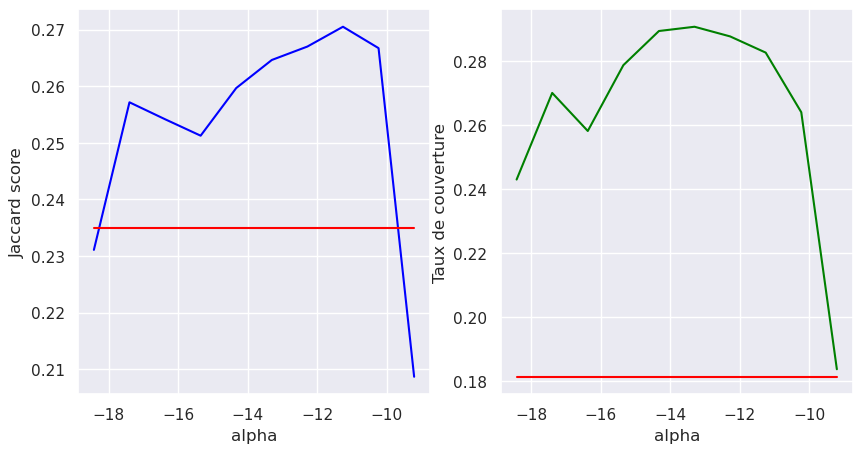

In [38]:
fig, axe = plt.subplots(1,2,figsize = (10,5))
axe = axe.flatten()
sns.lineplot(x=np.log(alphas), y=score, ax=axe[0], color='blue')
sns.lineplot(x=np.log(alphas), y=score_reference, ax=axe[0], color='red')
axe[0].set_xlabel('alpha')
axe[0].set_ylabel('Jaccard score')
sns.lineplot(x=np.log(alphas), y=coverage, ax=axe[1], color='green')
sns.lineplot(x=np.log(alphas), y=coverage_reference, ax=axe[1], color='red')
axe[1].set_xlabel('alpha')
axe[1].set_ylabel('Taux de couverture')
plt.savefig('../outputs/Jaccard score et taux de couverture en fonction de alpha (SGD_l1_bert).png')
plt.show()

In [39]:
alpha_optimal = alphas[np.argmax(coverage)]
alpha_optimal

1.6681005372000591e-06

In [40]:
score[np.argmax(coverage)]

0.26463965711070175

In [41]:
max(coverage)

0.2906333809523606

In [42]:
classifier = OneVsRestClassifier(SGDClassifier(alpha=alpha_optimal, penalty='l1', loss='log_loss', random_state=72))
classifier.fit(bert, y)

OneVsRestClassifier(estimator=SGDClassifier(alpha=1.6681005372000591e-06,
                                            loss='log_loss', penalty='l1',
                                            random_state=72))

In [43]:
params = {'algorithme' : 'SGDClassifier', 'loss' : 'log_loss', 'penalty' : 'l1', 'alpha_optimal' : alpha_optimal}
metrics = {'jaccard_score' : score[np.argmax(coverage)],
           'taux_de_couverture' : max(coverage)}
tags = {'Dataset' : 'BERT', 'algorithme' : 'SGDClassifier'}
artifacts = {'Evolution du Jaccard score et du taux de couverture en fonction de alpha' : 
             '../outputs/Jaccard score et taux de couverture en fonction de alpha (SGD_l1_bert).png'}

mt.log_mlflow_run('SGDClassifier_l1 (BERT)', params, metrics, tags=tags, artifacts=artifacts,\
                  model=classifier, model_name='SGDClassifier')

/home/chakir/anaconda3/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/home/chakir/anaconda3/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


## 3.5 Classification avec Embedding USE

### 3.5.1 CRÉATION DES EMBEDDINGS

À nouveau en raison de limitation en RAM, nous allons construire les embeddings par paquets.

In [16]:
import tensorflow_hub as hub

# Charger le modèle USE
model = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

# Fonction pour obtenir les embeddings USE (par lots)
def get_use_embeddings(texts, batch_size=32):
    all_embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        batch_embeddings = model(batch_texts).numpy()
        all_embeddings.append(batch_embeddings)
    return np.concatenate(all_embeddings, axis=0)

2024-05-28 21:51:45.032580: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-28 21:51:46.862802: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [17]:
# Obtenir les embeddings pour l'ensemble d'entraînement et de test
use = get_use_embeddings((data.Title + ' ' + data.Body).tolist())
use_val = get_use_embeddings((data_val.Title + ' ' + data_val.Body).tolist())

In [18]:
use.shape

(25000, 512)

### 3.5.2 RÉGRESSION LOGISTIQUE

In [19]:
debut = time()

classifier = OneVsRestClassifier(LogisticRegression())
classifier.fit(use, y)
y_pred = classifier.predict(use_val)

fin = time()

duree = fin - debut
print(f"Durée d'exécution : {round(duree/60)} minutes")

Durée d'exécution : 3 minutes


In [20]:
score_reference = jaccard_score(y_val, y_pred, average='weighted')
score_reference

0.264705773491394

In [21]:
tags_pred = pd.Series(binarizer.inverse_transform(y_pred), index=data_val.index).apply(lambda x: ' '.join(x))
coverage_reference = mt.coverage_score(tags_pred, data_val.Tags)
coverage_reference

0.20617517171715463

### 3.5.3 SGDClassifier AVEC UNE PÉNALITÉ L2

In [22]:
debut = time()

alphas = np.logspace(-8, -4, 10)
score = []
coverage = []

for alpha in alphas:
    classifier = OneVsRestClassifier(SGDClassifier(alpha=alpha, penalty='l2', loss='log_loss', random_state=72))
    classifier.fit(use, y)
    
    y_pred = classifier.predict(use_val)
    score.append(jaccard_score(y_val, y_pred, average='weighted'))
    
    tags_pred = pd.Series(binarizer.inverse_transform(y_pred), index=data_val.index).apply(lambda x: ' '.join(x))
    coverage.append(mt.coverage_score(tags_pred, data_val.Tags))

fin = time()

duree = fin - debut
print(f"Durée d'exécution : {round(duree/60)} minutes")

Durée d'exécution : 110 minutes


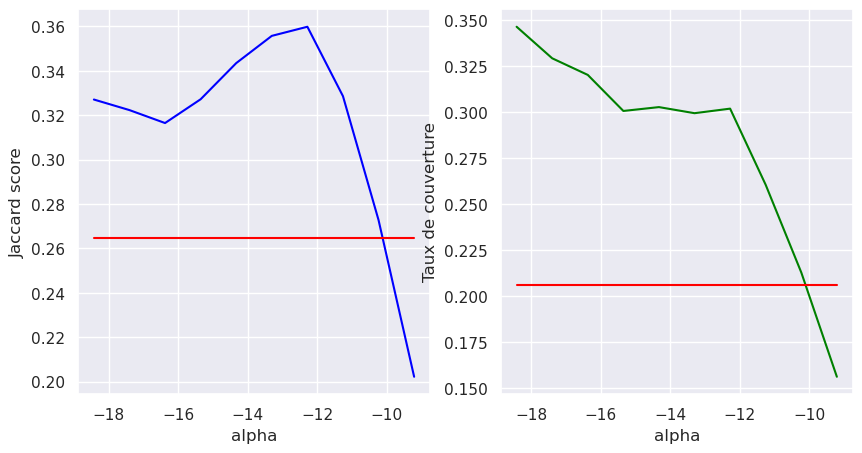

In [28]:
sns.set(style='darkgrid')
fig, axe = plt.subplots(1,2,figsize = (10,5))
axe = axe.flatten()
sns.lineplot(x=np.log(alphas), y=score, ax=axe[0], color='blue')
sns.lineplot(x=np.log(alphas), y=score_reference, ax=axe[0], color='red')
axe[0].set_xlabel('alpha')
axe[0].set_ylabel('Jaccard score')
sns.lineplot(x=np.log(alphas), y=coverage, ax=axe[1], color='green')
sns.lineplot(x=np.log(alphas), y=coverage_reference, ax=axe[1], color='red')
axe[1].set_xlabel('alpha')
axe[1].set_ylabel('Taux de couverture')
plt.savefig('../outputs/Jaccard score et taux de couverture en fonction de alpha (SGD_l2_use).png')
plt.show()

In [24]:
alpha_optimal = alphas[np.argmax(coverage)]
alpha_optimal

1e-08

In [25]:
score[np.argmax(coverage)]

0.32707980898230876

In [26]:
max(coverage)

0.3463055468975298

In [29]:
classifier = OneVsRestClassifier(SGDClassifier(alpha=alpha_optimal, penalty='l2', loss='log_loss', random_state=72))
classifier.fit(use, y)

OneVsRestClassifier(estimator=SGDClassifier(alpha=1e-08, loss='log_loss',
                                            random_state=72))

In [30]:
params = {'algorithme' : 'SGDClassifier', 'loss' : 'log_loss', 'penalty' : 'l2', 'alpha_optimal' : alpha_optimal}
metrics = {'jaccard_score' : score[np.argmax(coverage)],
           'taux_de_couverture' : max(coverage)}
tags = {'Dataset' : 'USE', 'algorithme' : 'SGDClassifier'}
artifacts = {'Evolution du Jaccard score et du taux de couverture en fonction de alpha' : 
             '../outputs/Jaccard score et taux de couverture en fonction de alpha (SGD_l2_use).png'}

mt.log_mlflow_run('SGDClassifier_l2 (USE)', params, metrics, tags=tags, artifacts=artifacts,\
                  model=classifier, model_name='SGDClassifier')

/home/chakir/anaconda3/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


### 3.5.4 SGDClassifier AVEC UNE PÉNALITÉ L1

In [31]:
debut = time()

alphas = np.logspace(-8, -4, 10)
score = []
coverage = []

for alpha in alphas:
    classifier = OneVsRestClassifier(SGDClassifier(alpha=alpha, penalty='l1', loss='log_loss', random_state=72))
    classifier.fit(use, y)
    
    y_pred = classifier.predict(use_val)
    score.append(jaccard_score(y_val, y_pred, average='weighted'))
    
    tags_pred = pd.Series(binarizer.inverse_transform(y_pred), index=data_val.index).apply(lambda x: ' '.join(x))
    coverage.append(mt.coverage_score(tags_pred, data_val.Tags))

fin = time()

duree = fin - debut
print(f"Durée d'exécution : {round(duree/60)} minutes")

Durée d'exécution : 232 minutes


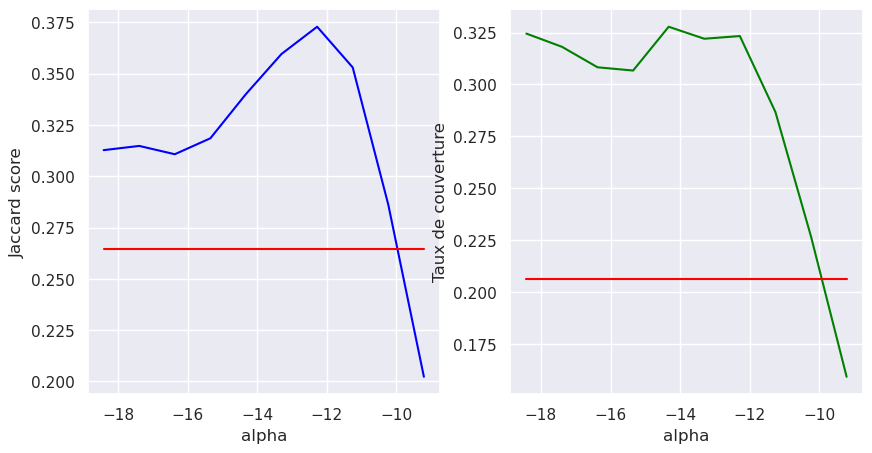

In [32]:
fig, axe = plt.subplots(1,2,figsize = (10,5))
axe = axe.flatten()
sns.lineplot(x=np.log(alphas), y=score, ax=axe[0], color='blue')
sns.lineplot(x=np.log(alphas), y=score_reference, ax=axe[0], color='red')
axe[0].set_xlabel('alpha')
axe[0].set_ylabel('Jaccard score')
sns.lineplot(x=np.log(alphas), y=coverage, ax=axe[1], color='green')
sns.lineplot(x=np.log(alphas), y=coverage_reference, ax=axe[1], color='red')
axe[1].set_xlabel('alpha')
axe[1].set_ylabel('Taux de couverture')
plt.savefig('../outputs/Jaccard score et taux de couverture en fonction de alpha (SGD_l1_use).png')
plt.show()

In [33]:
alpha_optimal = alphas[np.argmax(coverage)]
alpha_optimal

5.994842503189409e-07

In [34]:
score[np.argmax(coverage)]

0.34006757354267597

In [35]:
max(coverage)

0.3277772106781891

In [36]:
classifier = OneVsRestClassifier(SGDClassifier(alpha=alpha_optimal, penalty='l1', loss='log_loss', random_state=72))
classifier.fit(use, y)

OneVsRestClassifier(estimator=SGDClassifier(alpha=5.994842503189409e-07,
                                            loss='log_loss', penalty='l1',
                                            random_state=72))

In [37]:
params = {'algorithme' : 'SGDClassifier', 'loss' : 'log_loss', 'penalty' : 'l1', 'alpha_optimal' : alpha_optimal}
metrics = {'jaccard_score' : score[np.argmax(coverage)],
           'taux_de_couverture' : max(coverage)}
tags = {'Dataset' : 'USE', 'algorithme' : 'SGDClassifier'}
artifacts = {'Evolution du Jaccard score et du taux de couverture en fonction de alpha' : 
             '../outputs/Jaccard score et taux de couverture en fonction de alpha (SGD_l1_use).png'}

mt.log_mlflow_run('SGDClassifier_l1 (USE)', params, metrics, tags=tags, artifacts=artifacts,\
                  model=classifier, model_name='SGDClassifier')